<a href="https://colab.research.google.com/github/pyt3r/springboard-package/blob/master/capstone/1_Features_and_Target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Colab Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
root = pathlib.Path('/content/drive/MyDrive/home/Research/Springboard/Colab Notebooks')

Mounted at /content/drive


## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read OHLC Data

In [4]:
ohlc = pd.read_parquet( root / '1. ohlc.parquet' )
ohlc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-10,57020.10,58029.98,56419.41,57648.71,57648.71,2.885763e+10
2024-09-11,57650.29,57991.32,55567.34,57343.17,57343.17,3.704906e+10
2024-09-12,57343.17,58534.36,57330.10,58127.01,58127.01,3.383571e+10
2024-09-13,58130.32,60648.02,57650.11,60571.30,60571.30,3.249053e+10
2024-09-14,60569.12,60656.72,59517.88,60005.12,60005.12,1.642841e+10


## Moving Averages

In [5]:
def simpleMA( metric, window ):
  return metric.rolling( window ).mean()

def expMA( metric, window ):
  return metric.ewm( span=window, min_periods=window ).mean()

In [6]:
price = ohlc['Close']

window = 30

MA = pd.DataFrame({
    f'sma({window})': simpleMA(price, window),
    f'ema({window})': expMA(price, window), })

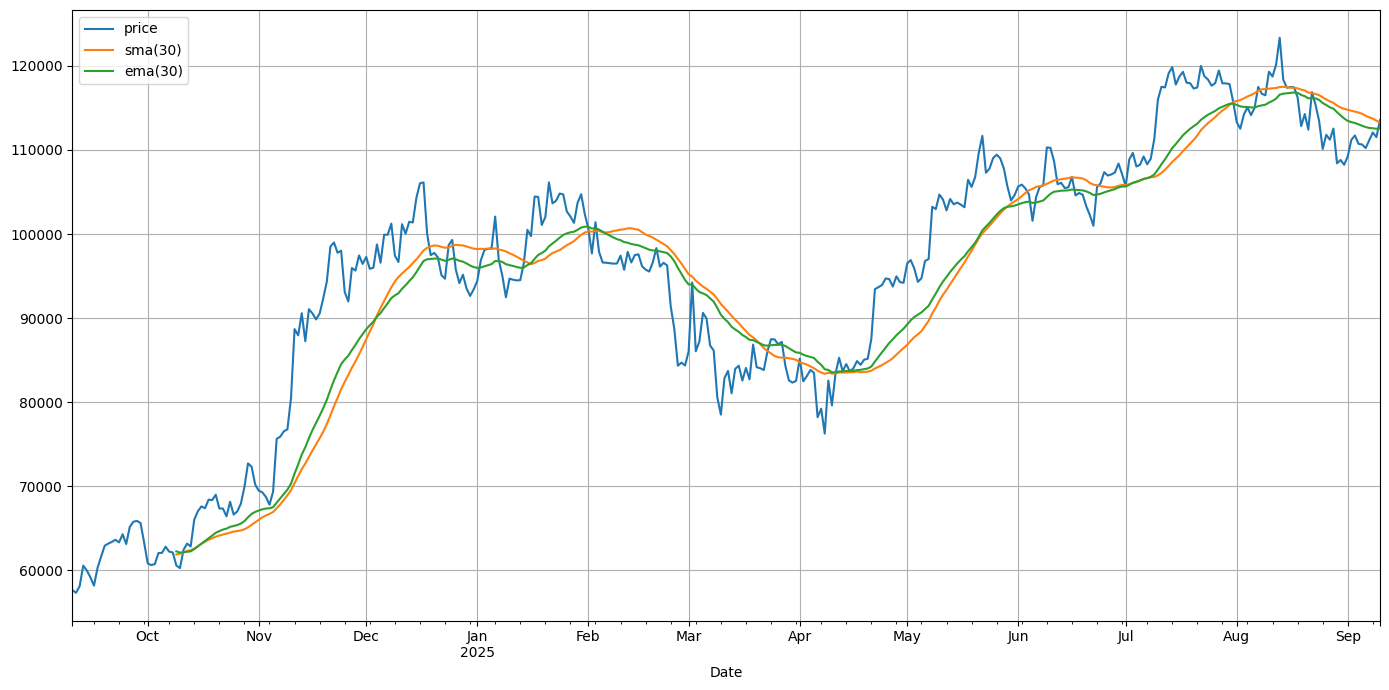

In [7]:
DF = pd.DataFrame({ 'price': price })
DF = pd.concat([ DF, MA ], axis=1 )
ax = DF.plot(figsize=(14, 7))
ax.grid(True)
plt.tight_layout()
plt.show()

## Crossover

In [8]:
def crossover( s1, s2, lag ):
  x = s1 - s2
  x = x * 0 + np.sign(x)
  return x.shift(lag)

In [9]:
price = ohlc['Close']

short_window = 15
long_window =  50
lag = 1

short = simpleMA(price, short_window)
long  = simpleMA(price, long_window)
cross = crossover(short, long, lag)

Crossover = pd.DataFrame({
    f'x(sma({short_window}),sma({long_window}))': cross, })

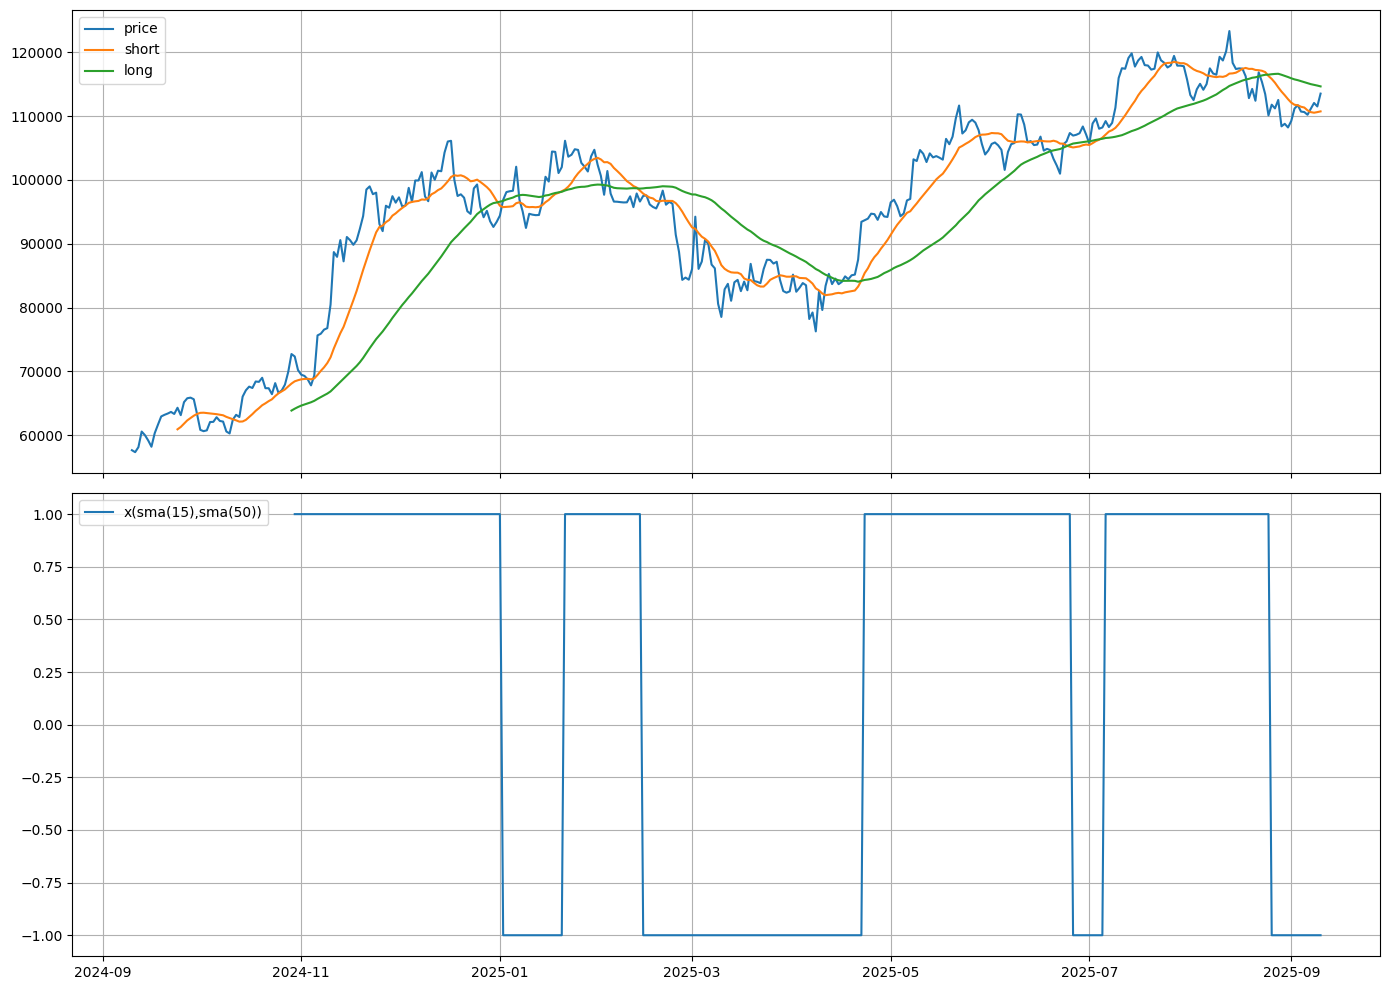

In [10]:
DF = pd.DataFrame({
    'price' : price,
    'short' : short,
    'long'  : long,
})
DF = pd.concat([ DF, Crossover ], axis=1 )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

top    = [ c for c in DF.columns if not c.startswith('x') ]
bottom = [ c for c in DF.columns if c not in top ]

for c in top:
  ax1.plot( DF[c], label=c )

for c in bottom:
  ax2.plot( DF[c], label=c )

for ax in [ax1, ax2]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

## Bollinger Bands

In [11]:
def bollUpper( metric, window, stdevs ):
    return boll( metric, window, abs( stdevs ))

def bollLower( metric, window, stdevs ):
    return boll( metric, window, -abs( stdevs ))

def boll( metric, window, stdevs ):
    ma = simpleMA( metric, window )
    std = stDev( metric, window )
    return ma + ( std * stdevs )

def stDev( metric, window ):
    return metric.rolling( window ).std()

In [12]:
price = ohlc['Close']

window = 20
stdevs = 2

results = [
    bollUpper(price, window, stdevs),
    bollLower(price, window, stdevs), ]

names = [
    f'bollUpper({window},{stdevs})',
    f'bollLower({window},{stdevs})', ]

Bollinger = pd.DataFrame(dict(zip(names, results)))

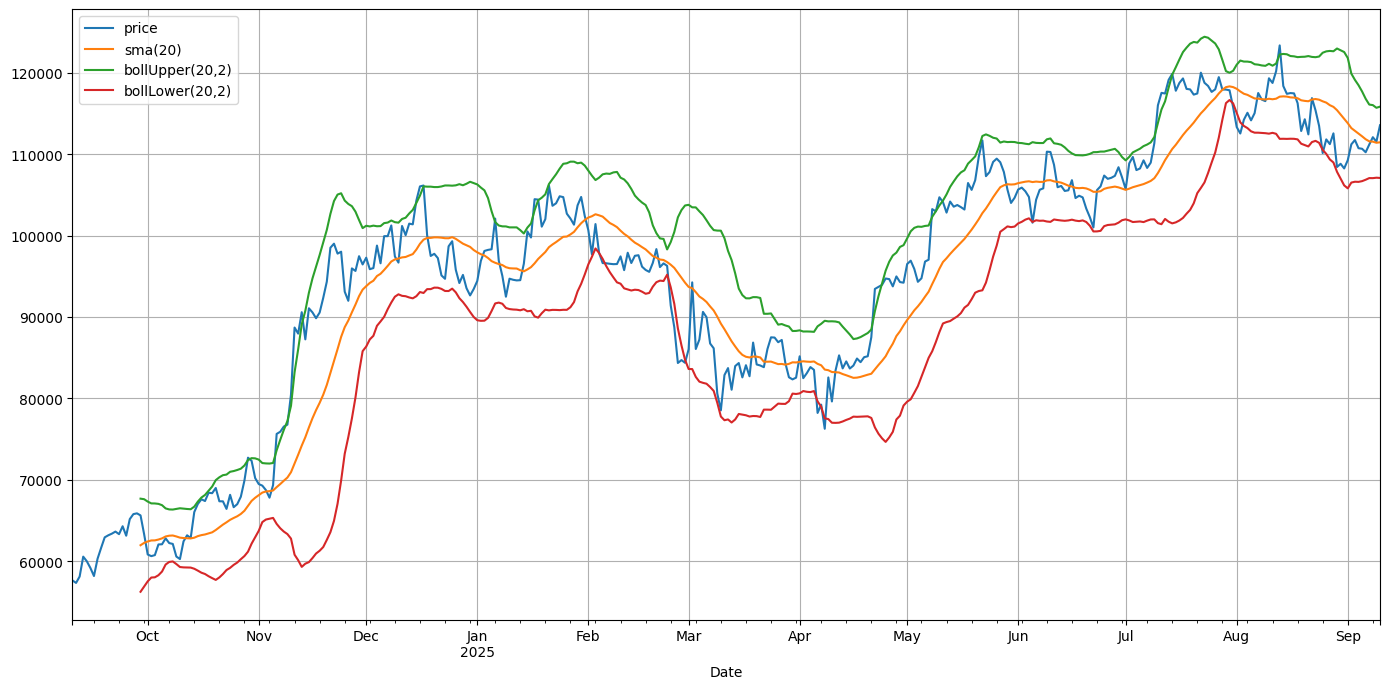

In [13]:
DF = pd.DataFrame({
    'price'          : price,
    f'sma({window})' : simpleMA(price, window),
})
DF = pd.concat([ DF, Bollinger ], axis=1 )
ax = DF.plot(figsize=(14, 7))
ax.grid(True)
plt.tight_layout()
plt.show()

### Moving Average Convergence Divergence (MACD)

Moving Average Convergence Divergence (MACD) involves the following three calculations; the last of which, the MACD distance, may be used by analysts in determining the magnitude of bullish or bearish momentum.

1. MACD is the difference between a long and short EMA.

2. The Signal Line is then the EMA of the MACD (#1).

3. The MACD Distance is the difference between the MACD (#1) and Signal Line (#2).

In [14]:
def macd(metric, short_window, long_window):
    short = expMA( metric, short_window )
    long = expMA( metric, long_window )
    return short - long

def macdDistance(macd_metric, signal_metric):
    return macd_metric - signal_metric

In [15]:
price = ohlc['Close']

short_window = 12
long_window = 26
signal_window = 9

short       = expMA( price, short_window )
long        = expMA( price, long_window )
macd_metric = macd( price, short_window, long_window )
signal      = expMA( macd_metric, signal_window )
macd_dist   = macdDistance( macd_metric, signal )

Macd = pd.DataFrame({
  f'macdDistance({short_window}, {long_window}, {signal_window})': macd_dist,
})

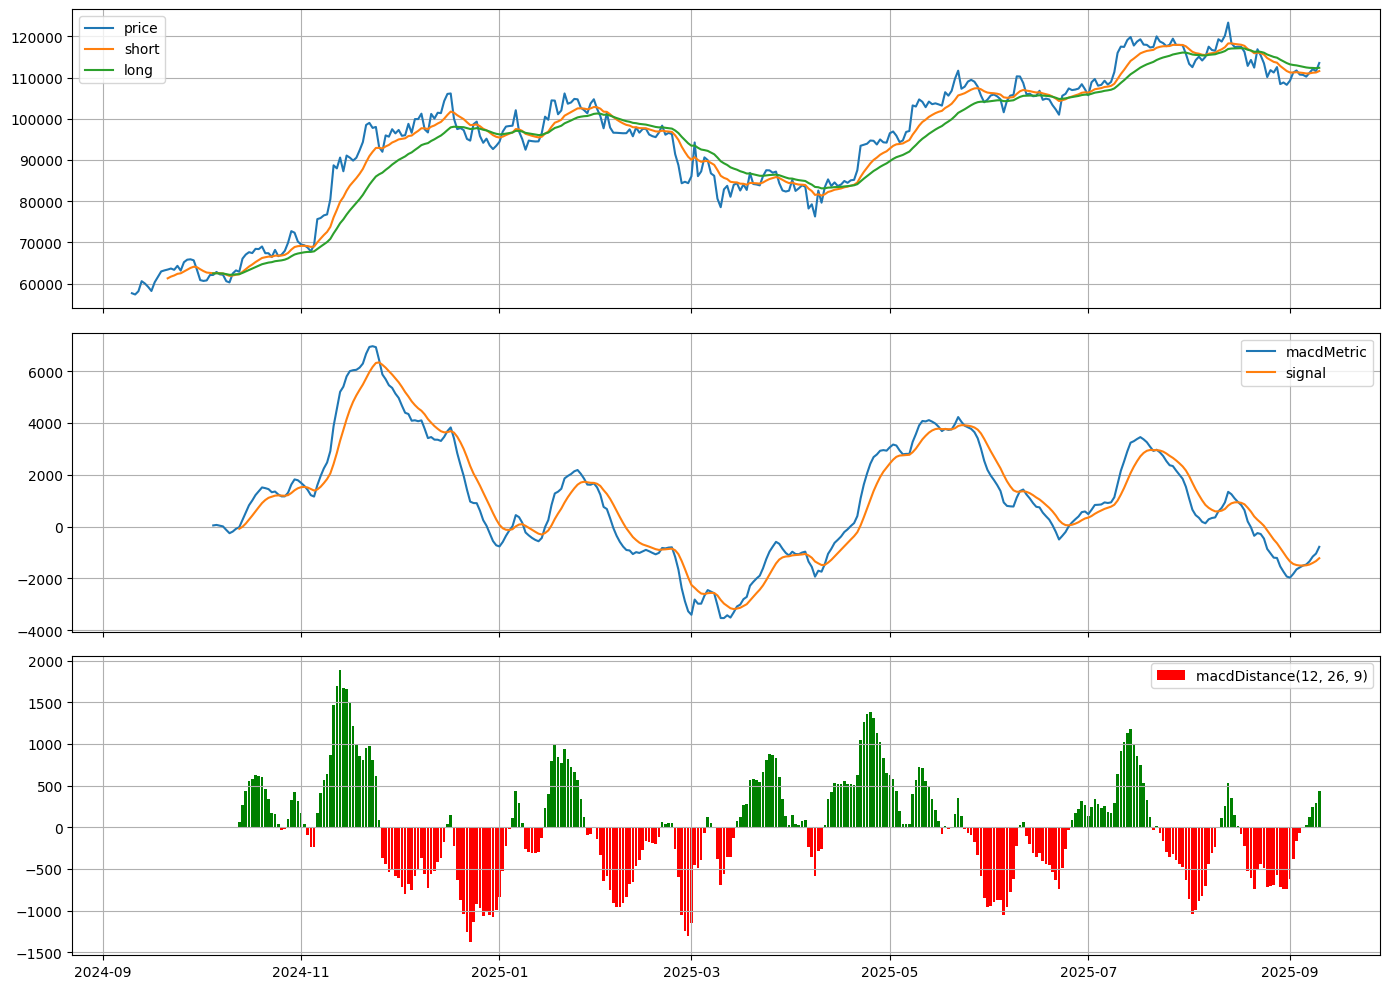

In [16]:
DF = pd.DataFrame({
    'price'     : price,
    'short'     : short,
    'macdMetric': macd_metric,
    'long'      : long,
    'signal'    : signal,
})
DF = pd.concat([ DF, Macd ], axis=1 )

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

top    = [ c for c in DF.columns if c.startswith(('price', 'short', 'long')) ]
middle = [ c for c in DF.columns if c.startswith(('macdMetric', 'signal')) ]
bottom = [ c for c in DF.columns if c.startswith(('macdDistance',)) ]

for c in top:
  ax1.plot( DF[c], label=c )

for c in middle:
  ax2.plot( DF[c], label=c )


for c in bottom:
  series = DF[c]
  colors = ['green' if v > 0 else 'red' for v in series]
  ax3.bar(DF.index, series, label=c, color=colors)

for ax in [ax1, ax2, ax3]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

## Oscillators

An oscillator is a trend indicator that fluctuates between an upper and a lower bound. Like Bollinger Bands, analysts use oscillators to help identify oversold and overbought signals.

Generally, an analyst might use a threshold above 70% or 80% to indicate an overbought asset, and a threshold below 30% or 20% to indicate an underbought asset.

### Stochastic Oscillator

In [17]:
def stochOscillator(metric, window):
    low = metric.rolling(window).min()
    high = metric.rolling(window).max()
    tmp = metric - low
    tmp /= high - low
    return tmp

In [18]:
price = ohlc['Close']

stoch_window = 14
sma_window = 3

stoch     = stochOscillator( price, stoch_window )
stock_sma = simpleMA( stoch, sma_window )

StochOscillator = pd.DataFrame({
    f'stoch({stoch_window})': stoch,
    f'stoch_sma({sma_window})': stock_sma,
})

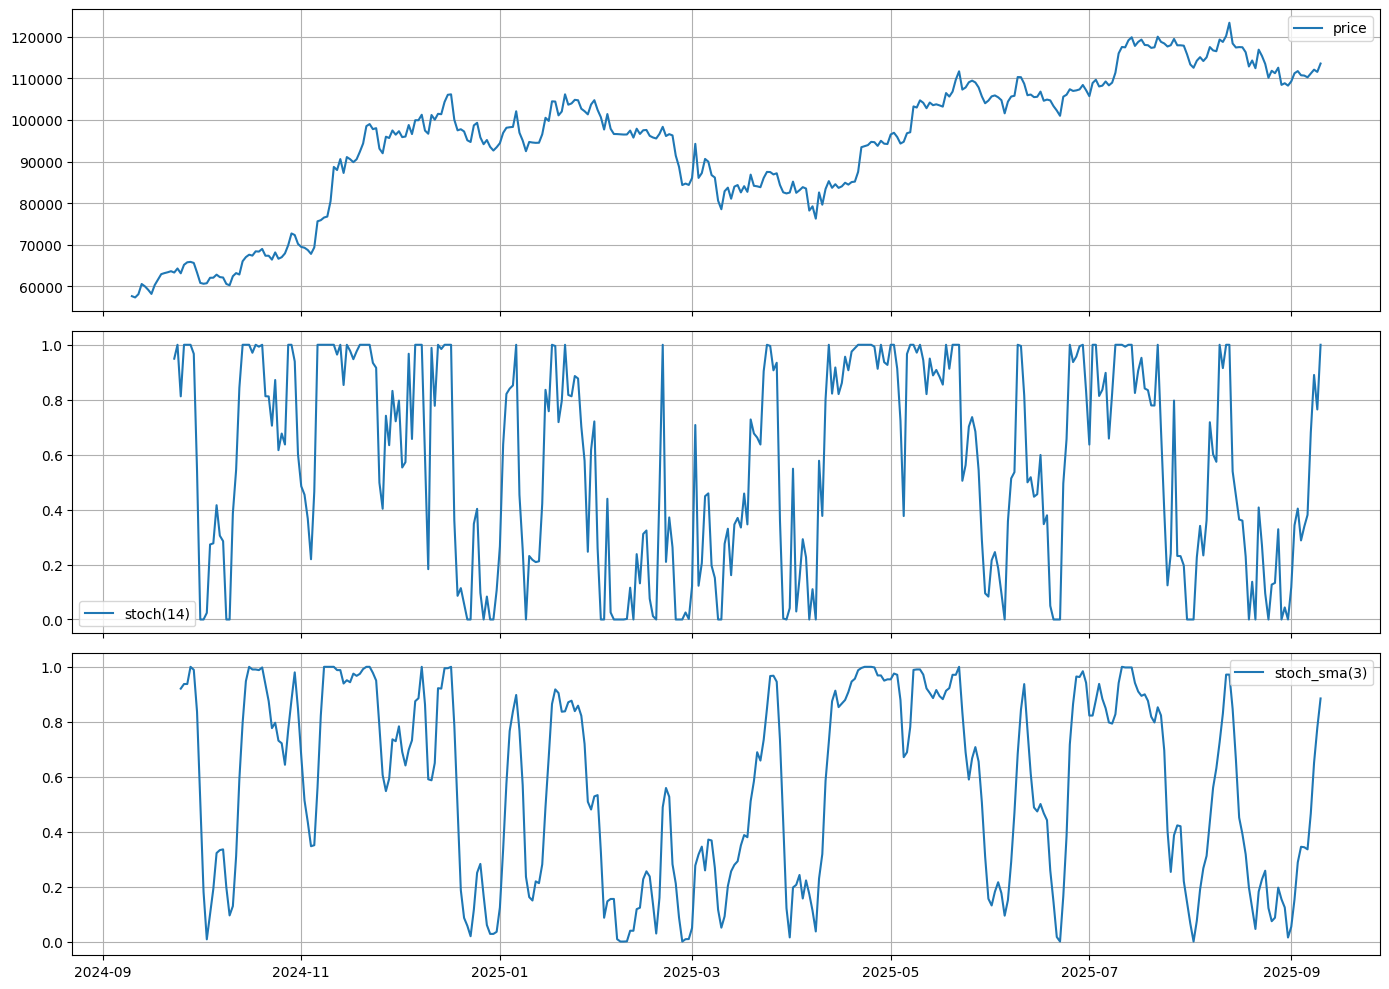

In [19]:
DF = pd.DataFrame({ 'price' : price, })
DF = pd.concat([ DF, StochOscillator ], axis=1 )

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

top    = [ c for c in DF.columns if c.startswith('price') ]
middle = [ c for c in DF.columns if c.startswith('stoch(') ]
bottom = [ c for c in DF.columns if c.startswith('stoch_sma(') ]

for c in top:
  ax1.plot( DF[c], label=c )

for c in middle:
  ax2.plot( DF[c], label=c )

for c in bottom:
  ax3.plot( DF[c], label=c )

for ax in [ax1, ax2, ax3]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

### Rate of Change (ROC)

In [20]:
def rocOscillator(metric, n):
    return metric.diff(n) / metric

In [21]:
price = ohlc['Close']

short_n = 10
medium_n = 50
long_n = 100

RocOscillator = pd.DataFrame({
    f'roc({short_n})' : rocOscillator(price, short_n),
    f'roc({medium_n})': rocOscillator(price, medium_n),
    f'roc({long_n})'  : rocOscillator(price, long_n),
})

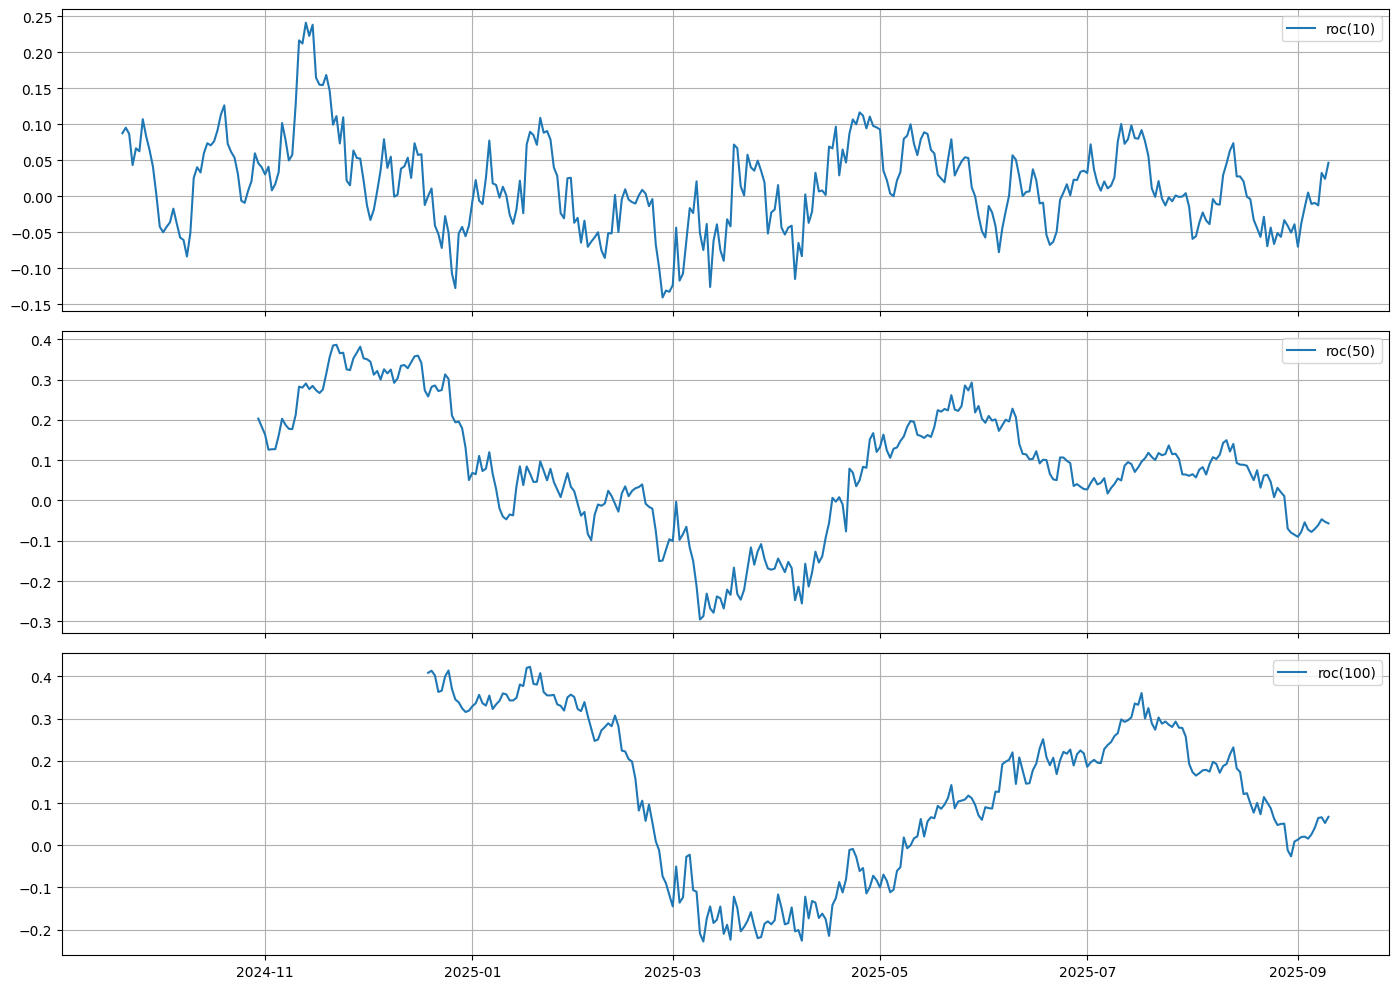

In [22]:
DF = pd.DataFrame( {'price' : price, })
DF = pd.concat([ DF, RocOscillator ], axis=1 )

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

top    = [ f'roc({short_n})' ]
middle = [ f'roc({medium_n})' ]
bottom = [ f'roc({long_n})' ]

for c in top:
  ax1.plot( DF[c], label=c )

for c in middle:
  ax2.plot( DF[c], label=c )

for c in bottom:
  ax3.plot( DF[c], label=c )

for ax in [ax1, ax2, ax3]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

### Relative Strength Index (RSI)

In [23]:
def rsiBase(metric, window, funcMA):
    diff = metric.diff()
    signs = np.sign(diff)
    isPositive = (signs + 1) / 2
    isNegative = (signs - 1).abs() / 2

    gain = isPositive * diff
    loss = isNegative * diff.abs()

    avgGain = funcMA(gain, window)
    avgLoss = funcMA(loss, window)

    rsi = avgGain / avgLoss
    rsi = 100 / (1 + rsi)
    return 100 - rsi

def rsiSma(metric, window):
    return rsiBase(metric, window, funcMA=simpleMA)

def rsiEma(metric, window):
    return rsiBase(metric, window, funcMA=expMA)

In [24]:
price = ohlc['Close']

window = 14

Rsi = pd.DataFrame({
    f'rsiSma({window})' : rsiSma(price, window),
    f'rsiEma({window})' : rsiEma(price, window),
})

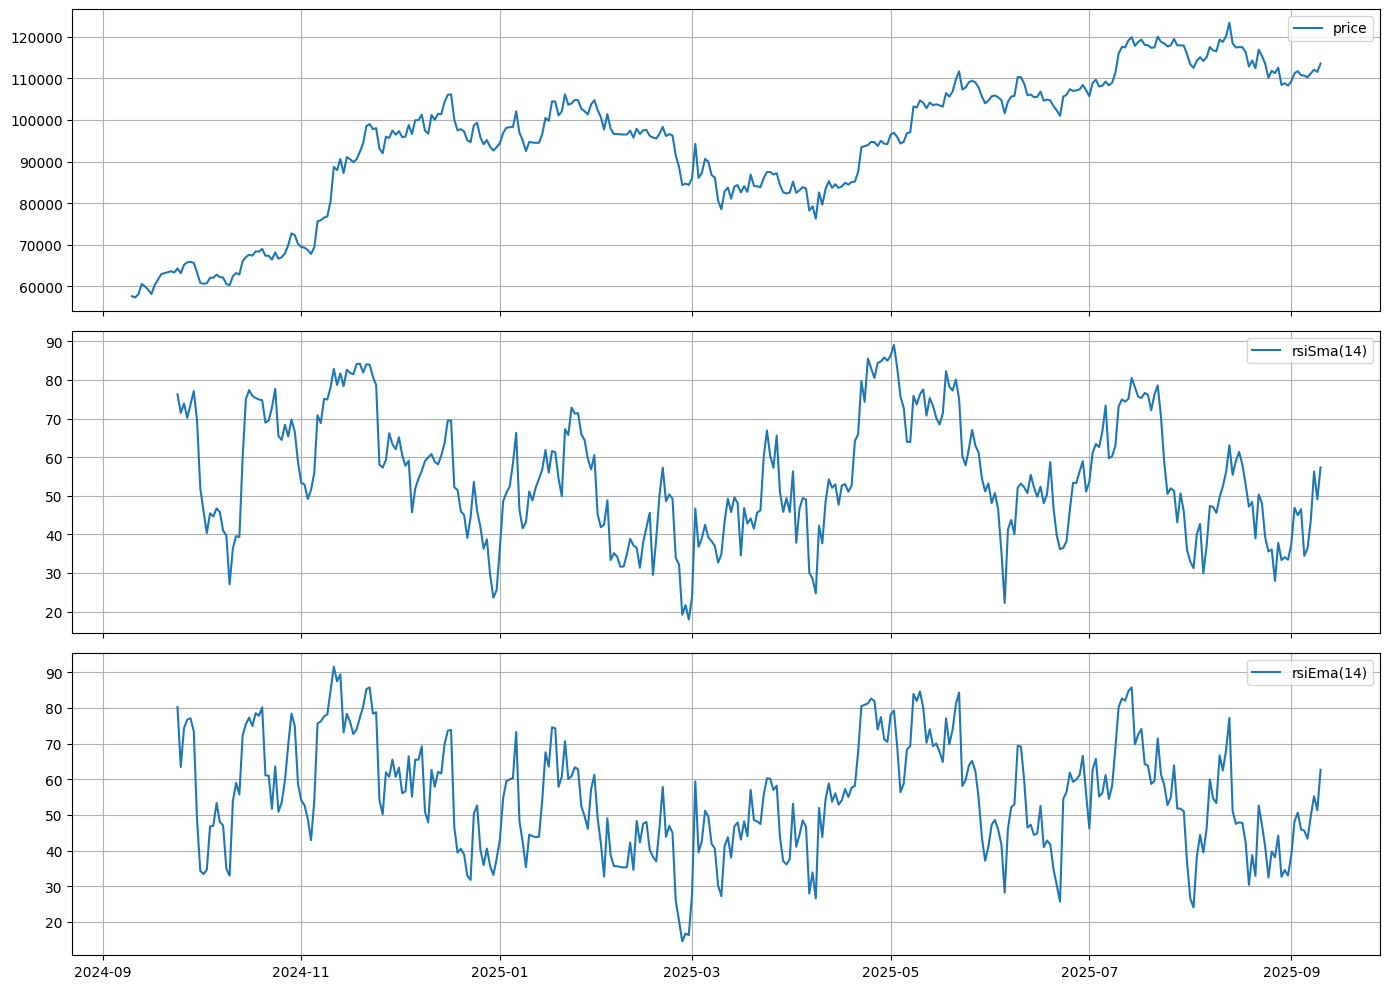

In [25]:
DF = pd.DataFrame({ 'price': price })
DF = pd.concat([ DF, Rsi ], axis=1 )

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

top    = [ c for c in DF.columns if c.startswith('price') ]
middle = [ c for c in DF.columns if c.startswith('rsiSma') ]
bottom = [ c for c in DF.columns if c.startswith('rsiEma') ]

for c in top:
  ax1.plot( DF[c], label=c )

for c in middle:
  ax2.plot( DF[c], label=c )

for c in bottom:
  ax3.plot( DF[c], label=c )

for ax in [ax1, ax2, ax3]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

### Money Flow Index (MFI)

Tracks price movement, weighted by how much money is behind the movement.

For example:
- As prices rise with increasing volume, MFI might confirm that there's genuine buying pressure.
- But if prices are rising while the MFI fails to follow suit, that can be a warning that the rally is on shaky ground

In [26]:
def mfi(high, low, close, volume, window):
    tmp = mfiRatio(high, low, close, volume, window)
    tmp += 1
    return 100 - (100 / tmp)

def mfiRatio(high, low, close, volume, window):
    price = typicalPrice(high, low, close)
    mf = rawMoneyFlow(high, low, close, volume)

    diff = price.diff()
    signs = np.sign(diff)
    isPositive = (signs + 1) / 2
    isNegative = (signs - 1).abs() / 2

    mf_positive = mf * isPositive
    mf_negative = mf * isNegative

    ratio = mf_positive.rolling(window).sum()
    ratio /= mf_negative.rolling(window).sum()
    return ratio

def rawMoneyFlow(high, low, close, volume):
    return typicalPrice(high, low, close) * volume

def typicalPrice(high, low, close):
    return (high + low + close) / 3

In [27]:
window = 14

high    = ohlc['High']
low     = ohlc['Low']
close   = ohlc['Close']
volume  = ohlc['Volume']

Mfi = pd.DataFrame({
    f'mfi({window})' : mfi(high, low, close, volume, window), })


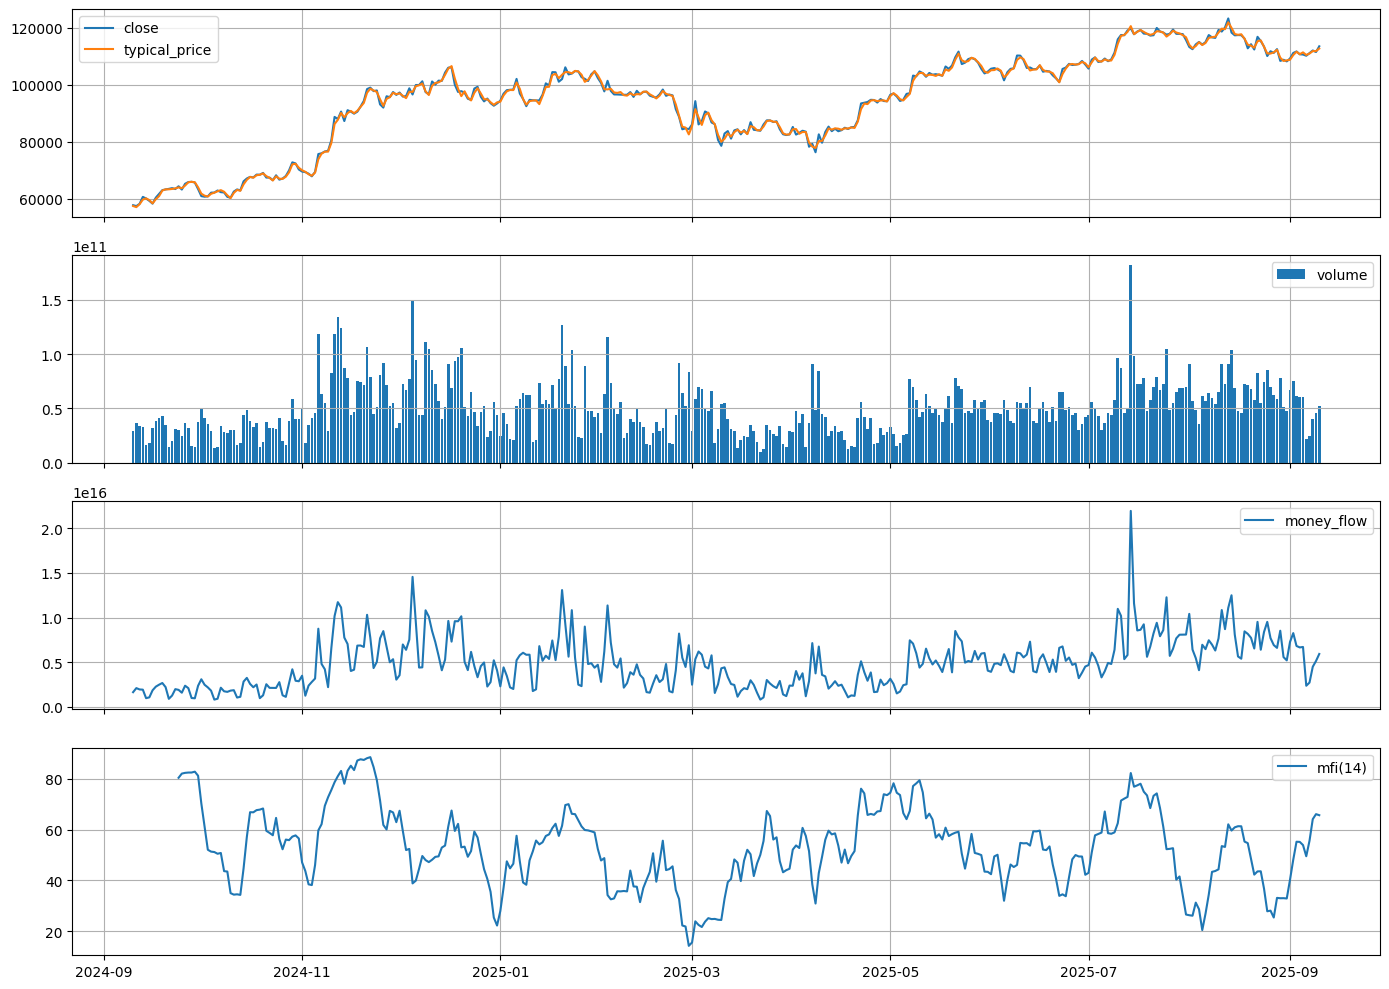

In [28]:
DF = pd.DataFrame({
    'close'          : close,
    'volume'         : volume,
    'typical_price'  : typicalPrice(high, low, close),
    'money_flow'     : rawMoneyFlow(high, low, close, volume),
})
DF = pd.concat([ DF, Mfi ], axis=1 )


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

top1   = [ c for c in DF.columns if c.startswith(('close', 'typical_price')) ]
top2   = [ 'volume' ]
middle = [ c for c in DF.columns if c.startswith('money_flow') ]
bottom = [ c for c in DF.columns if c.startswith('mfi') ]

for c in top1:
  ax1.plot( DF[c], label=c )

for c in top2:
  ax2.bar(DF.index, DF[c], label=c)

for c in middle:
  ax3.plot( DF[c], label=c )

for c in bottom:
  ax4.plot( DF[c], label=c )

for ax in [ax1, ax2, ax3, ax4]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

## Features


In [29]:
Features = pd.concat([
    MA,
    Crossover,
    Bollinger,
    Macd,
    Rsi,
    Mfi,
], axis=1 )

print(len(Features))
Features.tail()


366


,sma(30),ema(30),"x(sma(15),sma(50))","bollUpper(20,2)","bollLower(20,2)","macdDistance(12, 26, 9)",rsiSma(14),rsiEma(14),mfi(14)
Date,,,,,,,,,
2025-09-06,114061.796,112719.860474,-1.0,116790.061701,106850.665299,31.246031,36.390459,43.325287,49.517919
2025-09-07,113877.759,112619.715928,-1.0,116080.579405,107051.678595,123.447427,43.617566,49.689109,55.602814
2025-09-08,113730.128,112584.342642,-1.0,116010.442618,107045.840382,245.823697,56.274451,55.246898,64.088129
2025-09-09,113470.921,112516.356020,-1.0,115683.202514,107098.661486,287.940804,49.053761,51.331334,66.056176
2025-09-10,113297.830,112582.314986,-1.0,115824.018564,107069.814436,439.563315,57.328382,62.666593,65.646769


In [30]:
Features = Features.dropna()
print(len(Features))

316


## Target

In [31]:
price  = ohlc['Close']

shiftby  = -1
Target = ( price.diff().shift(shiftby) > 0 ).astype( int )
Target = Target.iloc[ :shiftby ] if shiftby < 0 else Target.iloc[ shiftby: ]
Target = Target.to_frame( 'Target' )


## Serialize

In [32]:
index = Target.index.intersection( Features.index )

Features.loc[ index ].to_parquet( root / '2. features.parquet')
Target.loc[ index ].to_parquet( root / '2. target.parquet')